### Modeling and visualizing dynamics of state COVID cases 

#### Anna Konstorum (konstorum.anna@gmail.com)

In [1]:
# import packages
import datetime
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
print(f'Last updated: {datetime.date.today()}')

Last updated: 2020-04-07


In [3]:
# import latest state data
url='https://covidtracking.com/api/states/daily.csv'
state_data=pd.read_csv(url,sep=',',header='infer', parse_dates=[0])

In [4]:
# create exponential function to model 
# will add additional functions shortly

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def quad_func(x,a,b,c):
    return a*x**2 +b*x+c

def lin_func(x,a,b):
    return a*x + b

In [5]:
def SSE_curve(x,y,fxn):
    popt,pop = curve_fit(fxn,x,y)
    y_exp= fxn(x, *popt)
    SSE = sum((y-y_exp)**2)
    return popt,SSE

In [6]:
# filter for IL
IL_data = state_data[state_data["state"]=="IL"]
IL_data=IL_data.sort_values(by="date")
IL_data.reset_index(inplace=True,drop=True)

In [8]:
# date range of the graph
start_date = min(IL_data['date'])
end_date = max(IL_data['date'])
next_date=end_date+datetime.timedelta(days=1)

print(f'Data from {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

Data from 2020-03-04 to 2020-04-07


In [9]:
# Textual date for labels
tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')
next2_label = (end_date + datetime.timedelta(days=2)).strftime('%m/%d')
next3_label = (end_date + datetime.timedelta(days=3)).strftime('%m/%d')

# get current date range
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)

# output date range as list
dates = [date.strftime('%m/%d') for date in date_range_plus]

In [10]:
# Get fraction of deaths
d_frac_df = pd.DataFrame(index=IL_data.index[13:],columns=['d_frac'])
d_frac_df['date'] = IL_data["date"][13:]
for i in IL_data.index[13:]:
    d = IL_data.iloc[i]['death']
    p = IL_data.iloc[i]['positive']
    d_frac = float("{:.4f}".format(d/p))
    d_frac_df.loc[i,'d_frac']=d_frac*100

In [11]:
d_frac_df.tail()

,d_frac,date
30,2.36,2020-04-03
31,2.35,2020-04-04
32,2.43,2020-04-05
33,2.5,2020-04-06
34,2.8,2020-04-07


In [12]:
# model fit for positive cases
xdata=np.array(IL_data.index)[-10:]

data_to_model=["positive"]
model_results=pd.DataFrame(index=data_to_model,columns=['a','b','c'])
xdata=np.array(IL_data.index)[-10:]
for item in data_to_model:
    ydata=np.array(IL_data[item])[-10:]
    
    popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    
    min_error=min(SSE_exp,SSE_quad,SSE_lin)
    
    if min_error == SSE_exp:
        model_results.loc[item,['a','b','c']]=popt_exp
        model_results.loc[item,'model']='exp'
    elif min_error == SSE_quad:
        model_results.loc[item,['a','b','c']]=popt_quad
        model_results.loc[item,'model']='quad'
    elif min_error == SSE_lin:
        model_results.loc[county,['a','b']]=popt_lin
        model_results.loc[county,'model']='lin'

In [13]:
model_results

,a,b,c,model
positive,29.7386,-732.386,4144.98,quad


In [14]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates)))
xdata_pred=np.array(range(len(dates)))[-11:]
xdata_dfrac = np.array(range(len(dates)))[13:-1]

In [15]:
#func use
def function_use(county,model_results):
    if model_results.loc[county]["model"]=='exp':
        func_use=exp_func
        opt_model = 'Exponential'
    elif model_results.loc[county]["model"]=='quad':
        func_use=quad_func
        opt_model = 'Quadratic'
    else:
        func_use=lin_func
        opt_model = 'Linear'
    return func_use, opt_model

### Illinois model and dynamics

In [16]:
next_day = xdata_pred[-1]
next2_day = next_day+1; next3_day = next_day+2
sub="[1] Schools close; [2] Stay-at-home order"

In [17]:
popt_state = model_results.loc["positive"][0:3]

func_use, opt_model = function_use("positive",model_results)

next_day_cases = func_use(next_day, popt_state[0], popt_state[1], popt_state[2])
next2_day_cases = func_use(next2_day, popt_state[0], popt_state[1], popt_state[2])
next3_day_cases = func_use(next3_day, popt_state[0], popt_state[1], popt_state[2])


loc = "Illinois"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

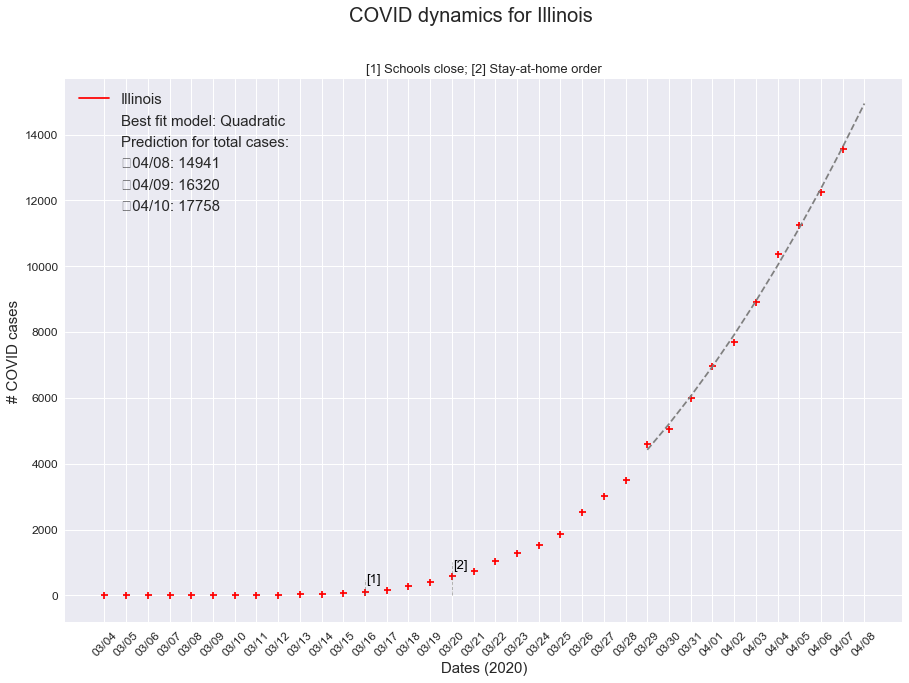

In [18]:
legend_elements =  [Line2D([0], [0], marker='+', color='red', label=loc, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_model), markersize=15),
                Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                   Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_cases)), markersize=1),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_cases)), markersize=15),
                   Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_cases)), markersize=15)]

plt.figure(figsize=(15,10))

plt.plot(xdata_pred, func_use(xdata_pred, *popt_state), color='grey',linestyle='--');
plt.scatter(IL_data.index,IL_data['positive'],color='red',marker='+');

plt.vlines(x=12, ymin=0, ymax=500,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(12.4,490,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=16, ymin=0, ymax=1000,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(16.4,900,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Illinois",fontsize=20);
plt.title(sub, fontsize=13);
   

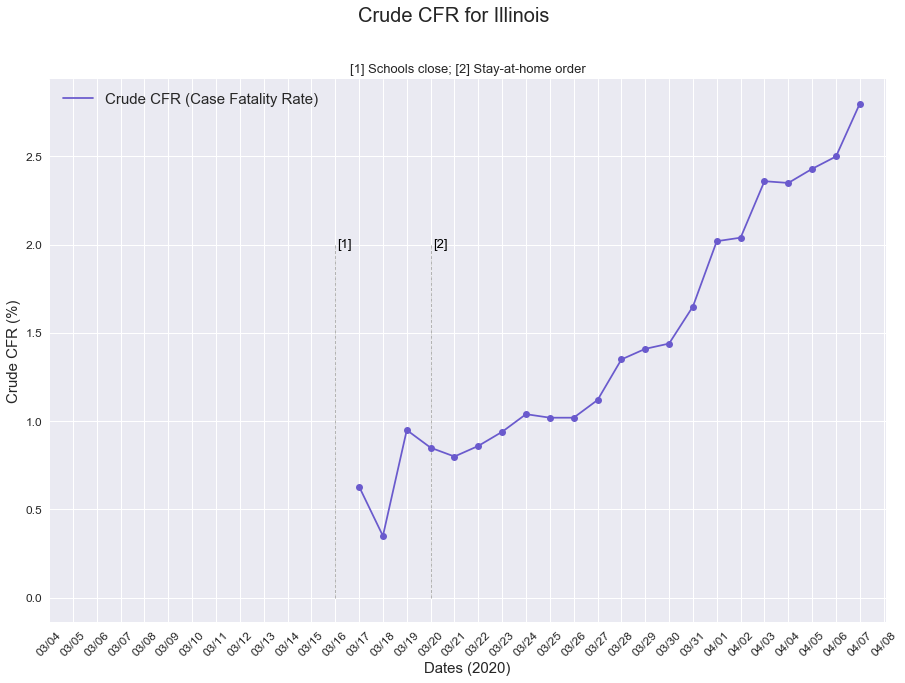

In [19]:
legend_elements =  [Line2D([0], [0], marker='+', color='slateblue', label="Crude CFR (Case Fatality Rate)", markersize=15)]

plt.figure(figsize=(15,10))

plt.plot(xdata_dfrac,d_frac_df["d_frac"],'o-',color='slateblue');
                               
plt.vlines(x=12, ymin=0, ymax=2,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(12.4,2,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=16, ymin=0, ymax=2,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(16.4,2,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');                              

plt.ylabel('Crude CFR (%)',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("Crude CFR for Illinois",fontsize=20);
plt.title(sub, fontsize=13);
   

In [20]:
##import latest county data
url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
county_data=pd.read_csv(url,sep=',',header='infer', parse_dates=[0])

In [21]:
state = county_data[county_data["state"]=='Illinois']
state['date_v2']=state['date'].dt.strftime('%m/%d')

/Users/annakonstorum/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
state.tail()

,date,county,state,fips,cases,deaths,date_v2
36306,2020-04-06,Whiteside,Illinois,17195.0,18,1,04/06
36307,2020-04-06,Will,Illinois,17197.0,697,19,04/06
36308,2020-04-06,Williamson,Illinois,17199.0,3,0,04/06
36309,2020-04-06,Winnebago,Illinois,17201.0,49,1,04/06
36310,2020-04-06,Woodford,Illinois,17203.0,6,0,04/06


In [23]:
state_f = state["date"]>="2020-03-04"
state_f = state[state_f]
counties=["McHenry","Lake","Cook"]

In [24]:
start_date=min(state_f["date"])
end_date=max(state_f["date"])
next_date=end_date+datetime.timedelta(days=1)
date_range=pd.date_range(start=start_date, end=end_date)
date_range_plus=pd.date_range(start=start_date,end=next_date)
dates = [date.strftime('%m-%d-%y') for date in date_range]
dates_plus = [date.strftime('%m-%d-%y') for date in date_range_plus]

tomorrow_label = (end_date + datetime.timedelta(days=1)).strftime('%m/%d')
next2_label = (end_date + datetime.timedelta(days=2)).strftime('%m/%d')
next3_label = (end_date + datetime.timedelta(days=3)).strftime('%m/%d')

In [25]:
county_d = pd.DataFrame(index=dates, columns=counties)
county_d.fillna(0,inplace=True)
county_c = pd.DataFrame(index=dates, columns=counties)
county_c.fillna(0,inplace=True)

for county in counties:
    county_spec = state_f[state_f["county"]==county]
    county_spec.index=county_spec['date']
    county_dates = [date.strftime('%m-%d-%y') for date in county_spec.index]
    for county_date in county_dates:
        county_c.loc[county_date,county]=county_spec.loc[county_date]["cases"]
        county_d.loc[county_date,county]=county_spec.loc[county_date]["deaths"]
        
county_c.reset_index(inplace=True,drop=False)
county_c.rename(columns={"index":"date"},inplace=True)

county_d.reset_index(inplace=True,drop=False)
county_d.rename(columns={"index":"date"},inplace=True)

In [26]:
# model fit for positive cases
xdata=np.array(county_c.index)[-10:]

select_counties=["Lake","Cook","McHenry"]
model_results_county=pd.DataFrame(index=select_counties,columns=['a','b','c'])
xdata=np.array(county_c.index)[-10:]
for item in select_counties:
    ydata=np.array(county_c[item])[-10:]
    popt_quad,SSE_quad = SSE_curve(xdata,ydata,quad_func)
    popt_lin,SSE_lin = SSE_curve(xdata,ydata,lin_func)
    try:
        popt_exp, SSE_exp = SSE_curve(xdata,ydata,exp_func)
        min_error=min(SSE_exp,SSE_quad,SSE_lin)
    except:
        min_error=min(SSE_quad,SSE_lin)
    
    if min_error == SSE_exp:
        model_results_county.loc[item,['a','b','c']]=popt_exp
        model_results_county.loc[item,'model']='exp'
    elif min_error == SSE_quad:
        model_results_county.loc[item,['a','b','c']]=popt_quad
        model_results_county.loc[item,'model']='quad'
    elif min_error == SSE_lin:
        model_results_county.loc[county,['a','b']]=popt_lin
        model_results_county.loc[county,'model']='lin'

In [27]:
model_results_county

,a,b,c,model
Lake,1.76894,-37.175,124.773,quad
Cook,15.3068,-192.883,-1492.99,quad
McHenry,0.935606,-41.6992,507.264,quad


In [28]:
# Include all dates, even those with missing data
xdata_full=np.array(range(len(dates_plus)))
xdata_pred=np.array(range(len(dates_plus)))[-11:]

In [29]:
next_day = xdata_pred[-1]
next2_day = next_day+1; next3_day = next_day+2
sub="[1] Schools close; [2] Stay-at-home order"

In [30]:
# Cook County

In [31]:
poptC = model_results_county.loc["Cook"][0:3]

func_useC, opt_modelC = function_use("Cook",model_results_county)

next_day_casesC = func_useC(next_day, poptC[0], poptC[1], poptC[2])
next2_day_casesC = func_useC(next2_day, poptC[0], poptC[1], poptC[2])
next3_day_casesC = func_useC(next3_day, poptC[0], poptC[1], poptC[2])

locC = "Cook County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

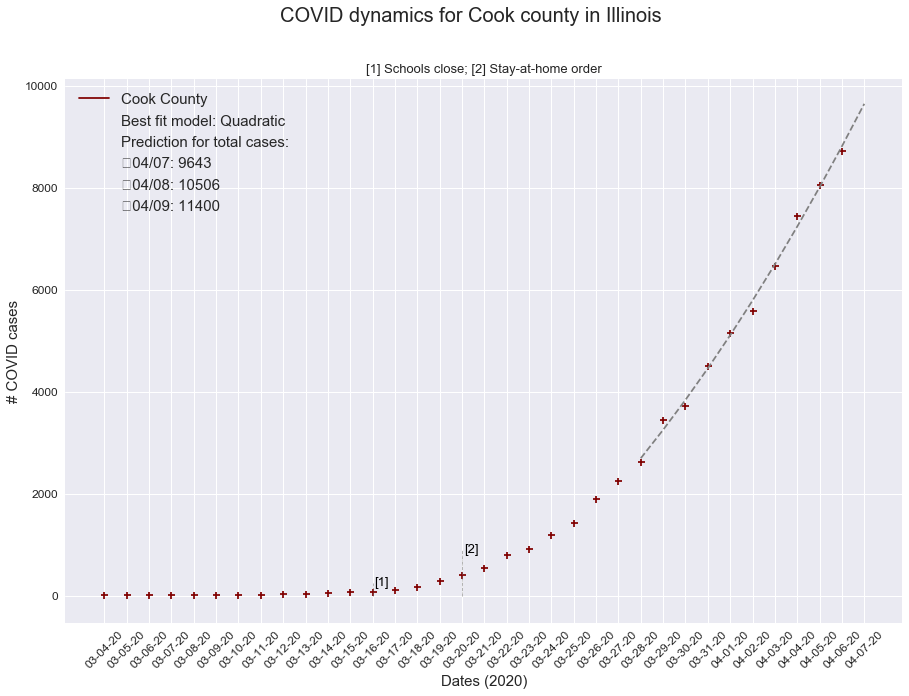

In [32]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='maroon', label=locC, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelC), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesC)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesC)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesC)), markersize=15)]
                

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useC(xdata_pred, *poptC), color='grey',linestyle='--')
plt.scatter(county_c.index,county_c['Cook'],color='maroon',marker='+')

plt.vlines(x=12, ymin=0, ymax=250,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(12.4,245,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=16, ymin=0, ymax=900,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(16.4,895,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates_plus, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for Cook county in Illinois",fontsize=20); 
plt.title(sub, fontsize=13);

In [33]:
# Lake AND McHenry

In [34]:
poptL = model_results_county.loc["Lake"][0:3]
poptM = model_results_county.loc["McHenry"][0:3]

func_useL, opt_modelL = function_use("Lake",model_results_county)
func_useC, opt_modelM = function_use("McHenry",model_results_county)

next_day_casesL = func_useL(next_day, poptL[0], poptL[1], poptL[2])
next2_day_casesL = func_useL(next2_day, poptL[0], poptL[1], poptL[2])
next3_day_casesL = func_useL(next3_day, poptL[0], poptL[1], poptL[2])

next_day_casesM = func_useC(next_day, poptM[0], poptM[1], poptM[2])
next2_day_casesM = func_useC(next2_day, poptM[0], poptM[1], poptM[2])
next3_day_casesM = func_useC(next3_day, poptM[0], poptM[1], poptM[2])

locL = "Lake County"
locM = "McHenry County"
model = "Best fit model: {}"
pred_text="Prediction for total cases:"
next_pred='\t{}: {}';

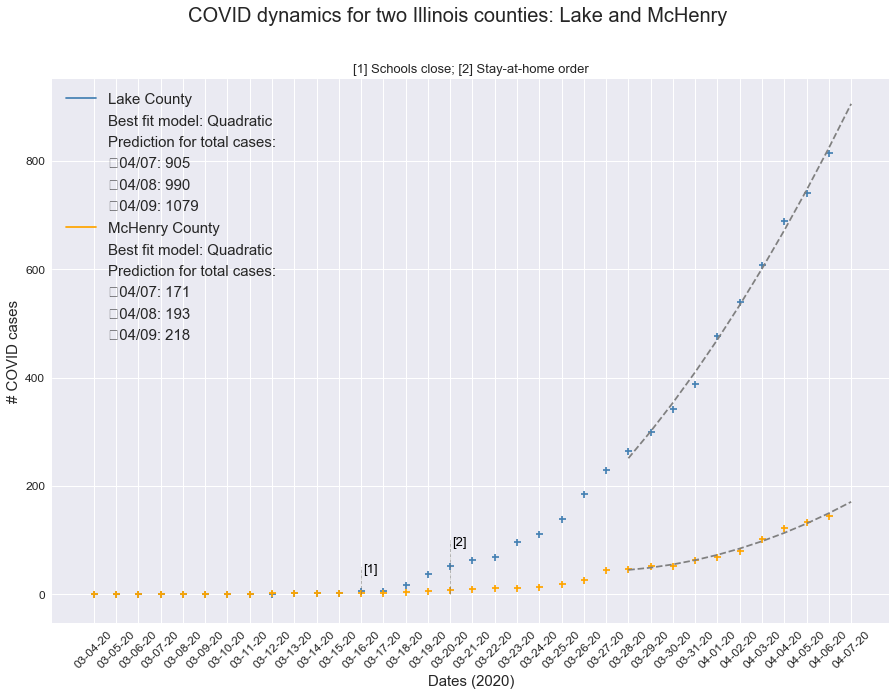

In [35]:
# Create legend
legend_elements =  [Line2D([0], [0], marker='+', color='steelblue', label=locL, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelL), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesL)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesL)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesL)), markersize=15),
                    Line2D([0], [0], marker='+', color='orange', label=locM, markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=model.format(opt_modelM), markersize=15),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=pred_text, markersize=1),
                    Line2D([1], [0], marker='', color='black',linestyle='', label=next_pred.format(tomorrow_label,int(next_day_casesM)), markersize=1),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next2_label,int(next2_day_casesM)), markersize=15),
                    Line2D([0], [0], marker='', color='black',linestyle='', label=next_pred.format(next3_label,int(next3_day_casesM)), markersize=15)]

plt.figure(figsize=(15,10));

plt.plot(xdata_pred, func_useL(xdata_pred, *poptL), color='grey',linestyle='--')
plt.scatter(county_c.index,county_c['Lake'],color='steelblue',marker='+')

plt.plot(xdata_pred, func_useC(xdata_pred, *poptM), color='grey',linestyle='--')
plt.scatter(county_c.index,county_c['McHenry'],color='orange',marker='+')

plt.vlines(x=12, ymin=0, ymax=50,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(12.4,45,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=16, ymin=0, ymax=100,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(16.4,95,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.ylabel('# COVID cases',fontsize=15);
plt.xticks(xdata_full, dates_plus, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("COVID dynamics for two Illinois counties: Lake and McHenry",fontsize=20); 
plt.title(sub, fontsize=13);

In [36]:
# Get fraction of deaths
d_frac_dfC = pd.DataFrame(index=county_c.index,columns=['d_frac'])
d_frac_dfC['date'] = county_c["date"]
for i in county_c.index:
    d = county_d.iloc[i]['Cook']
    p = county_c.iloc[i]['Cook']
    if p!=0:
        d_frac = float("{:.4f}".format(d/p))
        d_frac_dfC.loc[i,'d_frac']=d_frac*100

# Get fraction of deaths
d_frac_dfL = pd.DataFrame(index=county_c.index,columns=['d_frac'])
d_frac_dfL['date'] = county_c["date"]
for i in county_c.index:
    d = county_d.iloc[i]['Lake']
    p = county_c.iloc[i]['Lake']
    if p!=0:
        d_frac = float("{:.4f}".format(d/p))
        d_frac_dfL.loc[i,'d_frac']=d_frac*100
        
# Get fraction of deaths
d_frac_dfM = pd.DataFrame(index=county_c.index,columns=['d_frac'])
d_frac_dfM['date'] = county_c["date"]
for i in county_c.index:
    d = county_d.iloc[i]['McHenry']
    p = county_c.iloc[i]['McHenry']
    if p!=0:
        d_frac = float("{:.4f}".format(d/p))
        d_frac_dfM.loc[i,'d_frac']=d_frac*100

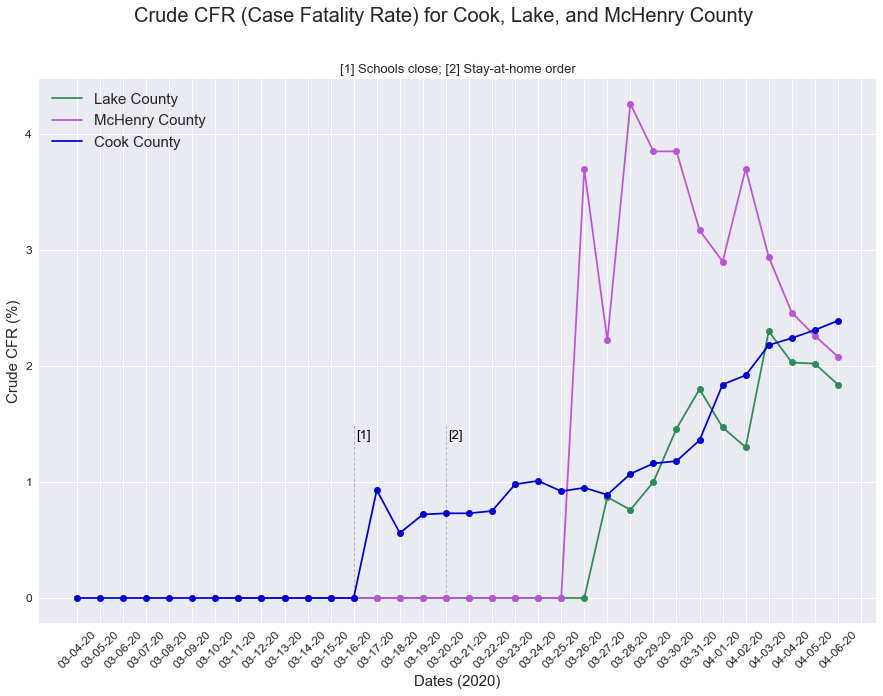

In [37]:
legend_elements =  [Line2D([0], [0], marker='+', color='seagreen', label="Lake County", markersize=15),
                   Line2D([0], [0], marker='+', color='mediumorchid', label="McHenry County", markersize=15),
                   Line2D([0], [0], marker='+', color='mediumblue', label="Cook County", markersize=15)]

plt.figure(figsize=(15,10))

plt.plot(d_frac_dfL.index,d_frac_dfL["d_frac"],'o-',color='seagreen');
plt.plot(d_frac_dfM.index,d_frac_dfM["d_frac"],'o-',color='mediumorchid');
plt.plot(d_frac_dfC.index,d_frac_dfC["d_frac"],'o-',color='mediumblue');
                               
plt.vlines(x=12, ymin=0, ymax=1.5,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(12.4,1.4,"[1]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');

plt.vlines(x=16, ymin=0, ymax=1.5,color='dimgrey', linewidth=0.5,linestyle='-.');
plt.text(16.4,1.4,"[2]",rotation=0,color='black',fontsize = 13,verticalalignment='center',horizontalalignment='center');                              

plt.ylabel('Crude CFR (%)',fontsize=15);
plt.xticks(xdata_full, dates, rotation=45,fontsize=12)  
plt.yticks(fontsize=12)
plt.xlabel('Dates (2020)',fontsize=15)
plt.legend(handles=legend_elements,fontsize=15,loc='upper left')
plt.suptitle("Crude CFR (Case Fatality Rate) for Cook, Lake, and McHenry County",fontsize=20);
plt.title(sub, fontsize=13);